In [19]:
import json
import nltk
import random
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nlp_function import pick_random_keys, stopwords_func, lower_processing, most_frequent_element

## Task 1

In [ ]:
## Read in data
# Read in training data (claim)
with open('../project-data/train-claims.json', 'r') as tclaim_file:
    tclaim_data = json.load(tclaim_file)

# Read in development data (claim)
with open('../project-data/dev-claims.json', 'r') as dclaim_file:
    dclaim_data = json.load(dclaim_file)

# Read in test data (claim)
with open('../project-data/test-claims-unlabelled.json', 'r') as uclaim_file:
    uclaim_data = json.load(uclaim_file)

# Read in evidence data
with open('../project-data/evidence.json', 'r') as evi_file:
    evi_data = json.load(evi_file)

## Preprocessing - Lowercase operation of the case
tclaim_data = lower_processing(tclaim_data, "claim_text")
dclaim_data = lower_processing(dclaim_data, "claim_text")
uclaim_data = lower_processing(uclaim_data, "claim_text")
evi_data = lower_processing(evi_data, 'evidence')

# ## Remove stopwords from claims and evidence (optional)
# stop_words = set(stopwords.words('english'))
# tclaim_data = stopwords_func(stop_words, "claim", tclaim_data)
# dclaim_data = stopwords_func(stop_words, "claim", dclaim_data)
# uclaim_data = stopwords_func(stop_words, "claim", uclaim_data)
# evi_data = stopwords_func(stop_words, "evidence", evi_data)

## Create claim-evidence pair based on training set
tkey_list = list(tclaim_data.keys())
train_pairs = []
evi_keys = []
labels = []
for i in tclaim_data:
    for j in tclaim_data[i]["evidences"]:
        evi_keys.append(j)
        train_pairs.append((i, tclaim_data[i]["claim_text"], evi_data[j], j))
        labels.append(1)
  
## insert negative sample to the training set
random.seed(1)
for i in tclaim_data:
    excluded_keys = tclaim_data[i]["evidences"]
    random_keys = pick_random_keys(evi_data, excluded_keys, len(excluded_keys))
    for j in random_keys:
        evi_keys.append(j)
        train_pairs.append((i, tclaim_data[i]["claim_text"], evi_data[j], j))
        labels.append(0)

In [ ]:
# Store the claim, evidence sentence(s) to list for embedded usage
claim_train_sentence = []
claim_dep_sentence = []
claim_test_sentence = []
evidence_full_sentence = []
evidence_sample_sentence = []

for i in tclaim_data.values():
    claim_train_sentence.append(i["claim_text"])
for i in dclaim_data.values():
    claim_dep_sentence.append(i["claim_text"])
for i in uclaim_data.values():
    claim_test_sentence.append(i["claim_text"])
for i in evi_data.values():
    evidence_full_sentence.append(i)
tfidf_keys = []
for i in train_pairs[:int(len(train_pairs)/2)]:
  evidence_sample_sentence.append(i[2])
  tfidf_keys.append(i[3])

In [11]:
# Topic Collection Step
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Keywords Selection
# Sample Evidence list of sentences
sentences = evidence_sample_sentence

# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Remove stopword from the tokenized sentences
# Remove non-pure-alphabet word from the tokenized sentences
stop_words = set(stopwords.words('english'))
for i in range(len(tokenized_sentences)):
    tokenized_sentences[i] = [word for word in tokenized_sentences[i] if word not in stop_words]
    tokenized_sentences[i] = [word for word in tokenized_sentences[i] if word.isalpha()]
tokenized_sentences_flat = [item for sublist in tokenized_sentences for item in sublist]
tokenized_sentences_flat = [x for x in tokenized_sentences_flat if len(x) > 2]
word_freq = Counter(tokenized_sentences_flat)

for num in range(1, 6):
    top_words = word_freq.most_common(20)
    topic_words = []
    for word, freq in top_words:
        topic_words.append(word)

    # Serach the full evidence set to find sentence that contains the topic word(s)
    topic_evidence_sentence = []
    topic_evidence_index = []
    for i in range(len(evidence_full_sentence)):
        token_evi = word_tokenize(evidence_full_sentence[i])
        for j in topic_words:
            if j in token_evi:
                topic_evidence_sentence.append(evidence_full_sentence[i])
                topic_evidence_index.append(i)
                break
    full_evidence_id = [k for k, v in evi_data.items()]
    topic_evidence_id = [full_evidence_id[i] for i in topic_evidence_index]

    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit the vectorizer on the training data
    tfidf_vectorizer.fit(claim_train_sentence + claim_dep_sentence + topic_evidence_sentence)

    # Transform the training and test data using the trained vectorizer
    evi_embeddings = tfidf_vectorizer.transform(topic_evidence_sentence)

    full_evidence_id = [k for k, v in evi_data.items()]

    for claim_id,claim_value in dclaim_data.items():
        test_claim_text = claim_value['claim_text']
        test_claim_emb = tfidf_vectorizer.transform([test_claim_text])
        evi_sim_dict = {}
        sim = cosine_similarity(test_claim_emb, evi_embeddings)[0]
        
        for i in range(len(sim)):
            evi_sim_dict[topic_evidence_id[i]] = sim[i]

        s_sim = [(k, v) for k, v in sorted(evi_sim_dict.items(), key=lambda item: item[1],reverse=True)][:num]
        sel_sim = [k for k,v in s_sim]
        dclaim_data[claim_id]["evidences"] = sel_sim

    # Save the test set result
    file_path = '../Performance/dev_topic/dev-claims-test_knn_' + str(num) + '.json'
    with open(file_path, 'w') as json_file:
        json.dump(dclaim_data, json_file)

[nltk_data] Downloading package punkt to /Users/relax/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/relax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
tfidf_vectorizer.fit(claim_train_sentence + claim_dep_sentence + topic_evidence_sentence)

# Transform the training and test data using the trained vectorizer
train_embeddings = tfidf_vectorizer.transform(claim_train_sentence)
evi_embeddings = tfidf_vectorizer.transform(topic_evidence_sentence)
test_embeddings = tfidf_vectorizer.transform(claim_test_sentence)
dev_embeddings = tfidf_vectorizer.transform(claim_dep_sentence)

In [ ]:
k = 1 # Current Optimal Performance
full_evidence_id = [k for k, v in evi_data.items()]

for claim_id,claim_value in uclaim_data.items():
    test_claim_text = claim_value['claim_text']
    test_claim_emb = tfidf_vectorizer.transform([test_claim_text])
    evi_sim_dict = {}
    sim = cosine_similarity(test_claim_emb, evi_embeddings)[0]
    
    for i in range(len(sim)):
        evi_sim_dict[topic_evidence_id[i]] = sim[i]

    s_sim = [(k, v) for k, v in sorted(evi_sim_dict.items(), key=lambda item: item[1],reverse=True)][:k]
    sel_sim = [k for k,v in s_sim]
    uclaim_data[claim_id]["evidences"] = sel_sim

# Save the test set result
file_path = '../Performance/test-claims-predictions.json'
with open(file_path, 'w') as json_file:
    json.dump(uclaim_data, json_file)

## Task 2

In [6]:
# Training data
train_data = claim_train_sentence + claim_dep_sentence

# Test data
test_data = claim_test_sentence

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
tfidf_vectorizer.fit(train_data)

# Transform the training and test data using the trained vectorizer
train_embeddings = tfidf_vectorizer.transform(train_data).toarray()
test_embeddings = tfidf_vectorizer.transform(test_data).toarray()

# Create training and test np.ndarray
train_np = train_embeddings[:len(claim_train_sentence)]
test_np = test_embeddings

In [7]:
# Collect similarity value for mojority voting operation
label_list = []
for i in test_np:
    similarity = []
    for j in train_np:
        similarity.append(cosine_similarity(np.reshape(i, (1, -1)), np.reshape(j, (1, -1)))[0][0])
    top_index = np.argsort(similarity)[-11:]
    label_list.append(list(top_index))

with open('../Performance/test-claims-predictions.json', 'r') as final_json:
    final_test = json.load(final_json)

# Obtain the most frequent label from the closest claim(s)
potential_label_list = []
train_key_list = list(tclaim_data.keys())
test_key_list = list(final_test.keys())
for i in range(len(label_list)):
    label_list_potential = []
    for j in label_list[i]:
        label_list_potential.append(tclaim_data[train_key_list[j]]["claim_label"])
    potential_label_list.append(label_list_potential)
    test_class = most_frequent_element(label_list_potential)
    final_test[test_key_list[i]]["claim_label"] = test_class

# Store to json
file_path = '../Performance/test-claims-predictions.json'
with open(file_path, 'w') as json_file:
    json.dump(final_test, json_file)

## Obtain Plot of Topic-Num vs. F-Score

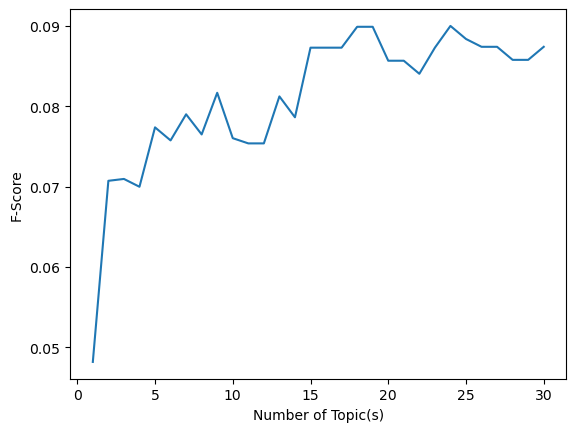

In [17]:
import matplotlib.pyplot as plt

dev_tfidf_topic_f = [0.048191094619666044, 0.07071737786023499, 0.07094928880643167, 0.0699752628324057, 0.07736549165120594, 0.07574211502782932, 0.07898886827458257, 0.07648423005565863, 0.08166357452071737, 0.0760204081632653, 0.07537105751391467, 0.07537105751391467, 0.08121521335807051, 0.0786178107606679, 0.08727581941867656, 0.08727581941867656, 0.08727581941867656, 0.08987322201607917, 0.08987322201607917, 0.08565244279529993, 0.08565244279529993, 0.08402906617192331, 0.08727581941867657, 0.08998144712430427, 0.08835807050092764, 0.08738404452690167, 0.08738404452690167, 0.08576066790352505, 0.08576066790352505, 0.08738404452690167]
topic_num  = list(range(1, 31))

# Example data
x = topic_num
y = dev_tfidf_topic_f

# Create a line plot
plt.plot(x, y)

# Set the title and axis labels
plt.xlabel('Number of Topic(s)')
plt.ylabel('F-Score')

# Display the plot
plt.show()

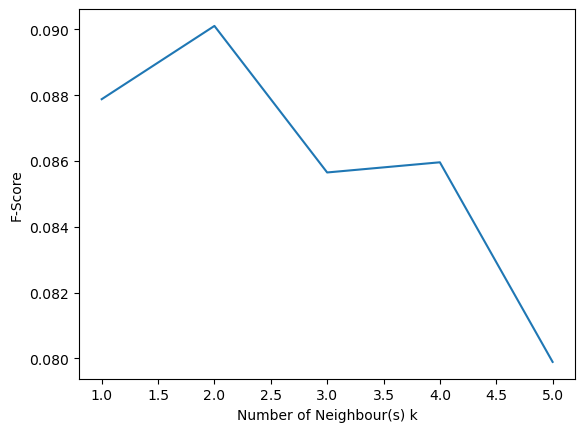

In [18]:
import matplotlib.pyplot as plt

dev_tfidf_topic_f = [0.08787878787878788, 0.09010513296227582, 0.08565244279529993, 0.08596165739022882, 0.07989589775304062]
topic_num  = list(range(1, 6))

# Example data
x = topic_num
y = dev_tfidf_topic_f

# Create a line plot
plt.plot(x, y)

# Set the title and axis labels
plt.xlabel('Number of Neighbour(s) k')
plt.ylabel('F-Score')

# Display the plot
plt.show()